- ### Planteamiento del problema:

Encontrar si existe relación entre los recursos sanitarios y los datos sociodemográficos.

In [77]:
# Se importa el dataset
import pandas as pd

url = 'https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
dataframe = pd.read_csv(url)

- ### Exploración y limpieza de datos:

In [78]:
# Primera apreciacion del dataset
filas = dataframe.shape[0]
columnas = dataframe.shape[1]
print(f'Filas: {filas} | Columnas: {columnas}')
print()
print(dataframe.info())

Filas: 3140 | Columnas: 108

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


In [79]:
nulos = dataframe.isnull().sum()
if len(nulos[nulos != 0]) == 0:

    print('No hay datos nulos')

else:

    print(nulos[nulos != 0])

No hay datos nulos


In [80]:
columnas = dataframe.columns.tolist()

for i in columnas:

    print(i)

fips
TOT_POP
0-9
0-9 y/o % of total pop
19-Oct
10-19 y/o % of total pop
20-29
20-29 y/o % of total pop
30-39
30-39 y/o % of total pop
40-49
40-49 y/o % of total pop
50-59
50-59 y/o % of total pop
60-69
60-69 y/o % of total pop
70-79
70-79 y/o % of total pop
80+
80+ y/o % of total pop
White-alone pop
% White-alone
Black-alone pop
% Black-alone
Native American/American Indian-alone pop
% NA/AI-alone
Asian-alone pop
% Asian-alone
Hawaiian/Pacific Islander-alone pop
% Hawaiian/PI-alone
Two or more races pop
% Two or more races
POP_ESTIMATE_2018
N_POP_CHG_2018
GQ_ESTIMATES_2018
R_birth_2018
R_death_2018
R_NATURAL_INC_2018
R_INTERNATIONAL_MIG_2018
R_DOMESTIC_MIG_2018
R_NET_MIG_2018
Less than a high school diploma 2014-18
High school diploma only 2014-18
Some college or associate's degree 2014-18
Bachelor's degree or higher 2014-18
Percent of adults with less than a high school diploma 2014-18
Percent of adults with a high school diploma only 2014-18
Percent of adults completing some college 

In [81]:
dataframe.dtypes.value_counts()

float64    61
int64      45
object      2
Name: count, dtype: int64

In [82]:
dataframe.columns[dataframe.dtypes == 'object']

Index(['COUNTY_NAME', 'STATE_NAME'], dtype='object')

- Inicialmente se puede observar que no existen valores nulos en ninguna de las variables.
- Hay 3.140 registros y 108 variables incluyendo la variable objetivo.
- Hay 2 variables categóricas y 106 numéricas.
- Se establece la variable objetivo a "Obesity_number", pues se relaciona con la salud de la población.

In [83]:
# Se verifica la existencia de duplicados
duplicados = dataframe.duplicated().sum()
print(f'Existen {duplicados} registros duplicados.')
print(f'El % de registros "duplicados" es {duplicados/filas}.')

Existen 0 registros duplicados.
El % de registros "duplicados" es 0.0.


No Existen datos duplicados en el dataframe.

- #### Se pretende hallar las variables de mayor relevancia para continuar con el análisis.

Ya que únicamente hay 2 variables categóricas, y además sólo representan el nombre del condado y del estado, no se tomarán en cuenta en el escalado de variables numéricas, ya que existen muchas más variables sociodemográficas que permitan un análisis más profundo.

In [84]:
dataframe.drop(dataframe.select_dtypes(include = ['object']).columns, axis =1, inplace = True)

In [85]:
# Escalado o normalizacion de las variables.

#Primero se separan los conjuntos de train y test
from sklearn.model_selection import train_test_split

X = dataframe.drop(['Obesity_number'], axis = 1)
y = dataframe['Obesity_number']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [86]:
n_columns = X.columns.tolist()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index = X_train.index, columns = n_columns)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index = X_test.index, columns = n_columns)

In [87]:
# Seleccionar las variables más relevantes
from sklearn.feature_selection import f_regression, SelectKBest

k = int(len(X_train.columns)*0.15)

selection_model = SelectKBest(f_regression, k = k)
selection_model.fit(X_train, y_train)
ix = selection_model.get_support()
X_train = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

print(X_train.columns)

Index(['TOT_POP', '0-9', '19-Oct', '40-49', 'POP_ESTIMATE_2018',
       'High school diploma only 2014-18',
       'Some college or associate's degree 2014-18',
       'Civilian_labor_force_2018', 'Total Population',
       'county_pop2018_18 and older', 'anycondition_number',
       'Heart disease_number', 'COPD_number', 'diabetes_number', 'CKD_number'],
      dtype='object')


In [88]:
columnas_deseadas = X_train.columns.tolist()
columnas_deseadas.append(y_train.name)
dataframe = dataframe[columnas_deseadas]

- ### Análisis Numérico-Numérico completo:

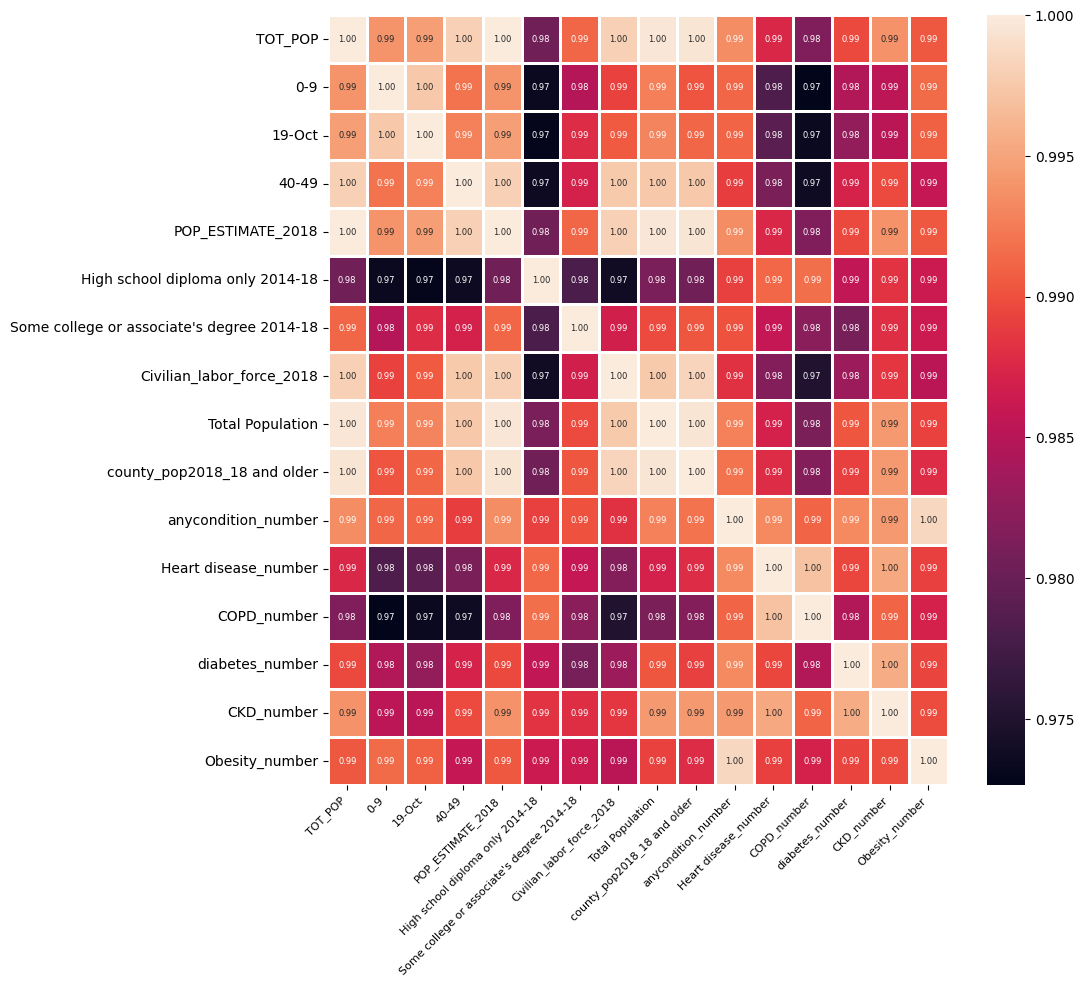

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,10))
corr = dataframe[dataframe.columns.tolist()].corr()

sns.heatmap(corr, annot = True, fmt = ".2f", annot_kws={'size': 6}, linewidths=2)

plt.xticks(rotation=45, ha='right', fontsize=8)

plt.show()

- Existe alto nivel de correlación lineal en todos los casos, por lo cual la existencia de multicolinealidad llevaría a usar el modelo Ridge, sin embargo, se usarán Lasso y Ridge en su forma estándar para evaluar cuál tiene mejor rendimiento.


In [90]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

modelos = {'Linear': LinearRegression(),
           'Lasso': Lasso(),
           'Ridge': Ridge()
}

In [91]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def prueba_modelos(modelos, X_train, X_test, y_train, y_test):

  result_training_r2 = {}
  root_error = {}

  for names, model in modelos.items():

    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)

    result_training_r2[names] = r2_score(y_test, y_predict)
    root_error[names] = np.sqrt(mean_squared_error(y_test, y_predict))

  return result_training_r2, root_error

In [92]:
result_training_r2, root_error = prueba_modelos(modelos, X_train, X_test, y_train, y_test)

/workspaces/EDA/EDA-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.146e+09, tolerance: 1.602e+09
  model = cd_fast.enet_coordinate_descent(


In [93]:
print('Raiz del error cuadrático medio:')
print(root_error)
print()
print("Coef. de determinación")
print(result_training_r2)

Raiz del error cuadrático medio:
{'Linear': 2266.708342768184, 'Lasso': 2415.653351680856, 'Ridge': 2440.225748470749}

Coef. de determinación
{'Linear': 0.9976502361217101, 'Lasso': 0.9973312852083288, 'Ridge': 0.997276715915959}


El error más bajo fue en el modelo Lasso, y el coef. de determinación fue el segundo mejor. Se buscará optimizarlo.

In [94]:
prueba_alpha = list(range(21))

/workspaces/EDA/EDA-env/lib/python3.11/site-packages/sklearn/base.py:1351: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/workspaces/EDA/EDA-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/workspaces/EDA/EDA-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.405e+09, tolerance: 1.602e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  

/workspaces/EDA/EDA-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.107e+09, tolerance: 1.602e+09
  model = cd_fast.enet_coordinate_descent(
/workspaces/EDA/EDA-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.621e+09, tolerance: 1.602e+09
  model = cd_fast.enet_coordinate_descent(
/workspaces/EDA/EDA-env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

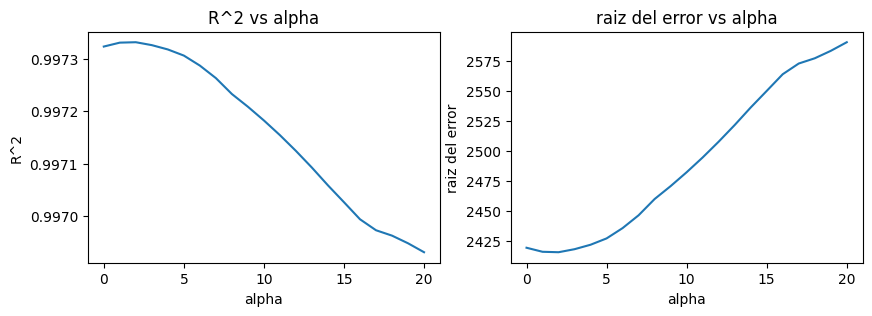

In [95]:
r2 = []
error = []

for i in prueba_alpha:

    model = Lasso(alpha = i)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    r2.append(r2_score(y_test, y_predict))
    error.append(np.sqrt(mean_squared_error(y_test, y_predict)))

fig, axis = plt.subplots(1, 2, figsize=(10,3))

axis[0].plot(prueba_alpha, r2)
axis[0].set_title('R^2 vs alpha')
axis[0].set_xlabel('alpha')
axis[0].set_ylabel('R^2')

axis[1].plot(prueba_alpha, error)
axis[1].set_title('raiz del error vs alpha')
axis[1].set_xlabel('alpha')
axis[1].set_ylabel('raiz del error')

plt.show()

In [96]:
r2_maximo = max(r2)
indice_r2_maximo = r2.index(r2_maximo)
alpha_maximo = prueba_alpha[indice_r2_maximo]
print(f'El R^2 maximo fue de {r2_maximo} y el valor alpha correspondiente fue de {alpha_maximo}')

El R^2 maximo fue de 0.9973320902756027 y el valor alpha correspondiente fue de 2


In [97]:
error_min = min(error)
indice_error_min = error.index(error_min)
alpha_min = prueba_alpha[indice_error_min]
print(f'La raiz del error cuadratico medio minimo fue de {error_min} y el valor alpha correspondiente fue de {alpha_min}')

La raiz del error cuadratico medio minimo fue de 2415.288960897156 y el valor alpha correspondiente fue de 2


Por lo visto anteriormente, para el valor de alpha 2, el modelo presento un mejor R^2 y se minimiza el error. Es allí donde el modelo se optimiza.

In [101]:
error_base = root_error['Lasso']
r2_base = result_training_r2['Lasso']

print(f'La diferencia entre R^2 base y optimizado fue de {r2_base - r2_maximo}')
print(f'La diferencia entre RMSE base y optimizado fue de {error_base - error_min}')

La diferencia entre R^2 base y optimizado fue de -8.05067273845772e-07
La diferencia entre RMSE base y optimizado fue de 0.36439078369994604


Esto demuestra que para el modelo optimizado, el R^2 aumentó y que además el RMSE disminuyó.